In [19]:
from qutip import mesolve, basis, jmat
import numpy as np
import scipy.linalg as la
from numpy import angle, pi
from qutip import Qobj, propagator, floquet_modes
import time as time
import matplotlib.pyplot as plt

def floquet_modes_phtr(H, T, args=None, parallel=False, sort=False, U=None):
    if 'opts' in args:
        options = args['opts']
    else:
        options = Options()
        options.rhs_reuse = True
        rhs_clear() 
    
    if U is None:
        U = propagator(H, T, [], args, options=options)
    
    evals, evecs = la.eig(U.full())

    eargs = angle(evals)
    eargs += (eargs <= -pi) * (2 * pi) + (eargs > pi) * (-2 * pi)
    e_quasi = -eargs / T

    if sort:
        order = np.argsort(-e_quasi)
    else:
        order = list(range(len(evals)))

    new_dims = [U.dims[0], [1] * len(U.dims[0])]
    new_shape = [U.shape[0], 1]
    kets_order = [Qobj(np.matrix(evecs[:, o]).T,
                       dims=new_dims, shape=new_shape) for o in order]

    return kets_order, e_quasi[order]


def drive_exact(t, args):
    w = args['omega']
    h = args['h']
    h0 = args['h0']
    return h * np.cos(w*t) + h0

def get_hamiltonians_exact(args):
    N = args['N']
    sx,sy,sz = jmat(N,"x"),jmat(N,"y"),jmat(N,"z")
    kn =  2.0/(N-1)                                      # kacNorm
    H0 = kn * sz **2
    H1 = 2 * sx
    return H0,H1

def floq_evolv_exact(args):
    T = 2 * np.pi/args['omega']
    H0, H1 = get_hamiltonians_exact(args)
    H = [H0,[H1,drive_exact]]
    f_states, _ = floquet_modes_mod(H, T, args=args)
    return f_states

def floq_evolv_exact_sten(args):
    w = args['omega']
    T = 2 * np.pi/w
    H0, H1 = get_hamiltonians_exact(args)
    H = [H0,[H1,drive_exact]]
    f_modes_0, f_energies = floquet_modes_phtr(H, T, args=args)
    return [w, f_modes_0, f_energies]

print('definition done!')

definition done!


In [20]:
import numpy as np
import matplotlib.pyplot as plt
from multiprocessing import Pool
from scipy.special import jn_zeros, j0
import math
from qutip import Options
from functions_needed_phase_study import*
import h5py, time
freezing_pts = jn_zeros(0, 500)
start = time.time()

Ns = [10,30]
ostp = [1e5, 1e5]
frz_jnth = [3,3]

# which number of floquet mode we take
nth = 0           
# number of freezing point
#frz_nth = 20
h0 = np.sqrt(3)/2**4
ws = np.exp(np.linspace(np.log(.1), np.log(100), 40))

ws1 = np.exp(np.linspace(np.log(0.01), np.log(0.1), 4))
ws2 = np.exp(np.linspace(np.log(0.2), np.log(0.9), 10))
ws3 = np.exp(np.linspace(np.log(1.0), np.log(30.0), 20))
ws4 = np.exp(np.linspace(np.log(35.0), np.log(200), 5))
#ws = np.concatenate((ws1,ws2,ws3,ws4))

if __name__ == '__main__':
    nprocs = 2
    #opts = Options(nsteps=1e4)    
    
    for nn,N in enumerate(Ns):
        start1 = time.time()
        opts = Options(nsteps = ostp[nn])
        frz_nth = int(frz_jnth[nn]) 
        params = [{'h0':h0, 'h': 1/4 * w * freezing_pts[frz_nth], 'omega':w, 'N':N, 'opts':opts} for w in ws]
        p = Pool(processes = nprocs)  

        data = np.array(p.map(floq_evolv_exact_sten,params))

        w_f = np.array(data[:,0])
        evec_ff = np.array(data[:,1])
        phs_f = np.array(data[:,2])

        evec_f = np.array([np.array([np.array(evec_ff[j][i])[:,0].real for i in range(int(2*N+1))]) for j in range(len(ws))])

        evals_single_path = np.zeros(len(ws))
        iprmat_single_path = np.zeros(len(ws))
        iprmat = np.zeros((len(ws),2*N+1))

        sx = jmat(N,"x")
        en, st = sx.eigenstates()

        for xx,w in enumerate(ws):
            #Get the previous Floquet Eigensystem
            if xx == 0:
                evals_prev = phs_f[xx].real
                evecs_prev = evec_f[xx]
            else:
                evals_prev = phs_f[xx-1].real
                evecs_prev = evec_f[xx-1]

            #Sort the Floquet states of this itertaion accordingly to orthonormality with the previous ones
            evals_curr = phs_f[xx]
            evecs_curr = evec_f[xx]
            t = np.copy(evecs_curr)
            condition = np.abs(np.around(evecs_prev.T.conj() @ evecs_curr, 1))
            evals_curr = evals_curr[np.argmax(condition, axis=1)]        
            evecs_curr = evecs_curr[:,np.argmax(condition, axis=1)]

            evals_single_path[xx] = evals_curr[nth]

            f_states = evec_f[xx]
            iprmat[xx,:] = [np.sum([np.abs(Qobj(state).overlap(sx_ev))**4 for sx_ev in st], axis=-1) for state in f_states]

            iprmat_single_path[xx] = iprmat[xx,:][nth]
               
        # save the data
        filename = 'phase_transition_11N_check_' + str(N) +'_.hdf5'

        with h5py.File(filename, 'w') as hf:
            hf.create_dataset('ws', np.shape(ws), data=ws)
            hf.create_dataset('evals_single_path', np.shape(evals_single_path), data=evals_single_path)
            hf.create_dataset('iprmat_single_path', np.shape(iprmat_single_path), data=iprmat_single_path)
            hf.attrs['N'] = N
            hf.attrs['frz_nth'] = frz_nth
            hf.attrs['nth'] = nth
        
        print("For N = ", N, "with", nprocs, "processors : time taken ", (time.time()-start1)/60, ' minutes !')
    print('\n run complete!! \n\n TOTAL TIME TAKEN :', (time.time()-start)/60, ' minutes !')

/tmp/ipykernel_7250/4223202209.py:40: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data = np.array(p.map(floq_evolv_exact_sten,params))


For N =  10 with 2 processors : time taken  0.2120941718419393  minutes !
For N =  30 with 2 processors : time taken  2.6054444471995035  minutes !

 run complete!! 

 TOTAL TIME TAKEN : 2.817585829893748  minutes !


In [21]:
!ls phase_transition_11N_check_* > file_phasetran.txt
!cat file_phasetran.txt

phase_transition_11N_check_10_.hdf5
phase_transition_11N_check_30_.hdf5


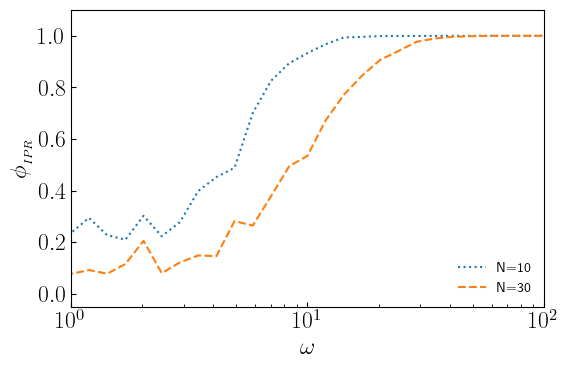

CPU times: user 543 ms, sys: 67.8 ms, total: 611 ms
Wall time: 1.81 s


In [22]:
%%time
import matplotlib.pyplot as plt
import h5py

plt.rcParams.update({ "figure.figsize": (6, 4),"text.usetex": True,"font.family": "sans-serif",
    "font.size": 17, "font.sans-serif": ["Computer Modern"]})


with open("file_phasetran.txt", 'r') as fp:
    lines = fp.readlines()
    x = len(lines)
    j =0
    
    linest = ['dotted', 'dashed', 'dashdot','solid']
    for i in range(0,x):
        filename = lines[i][:-1]
        with h5py.File(filename, 'r') as f:    
            ws = f['ws'][()]
            evals_single_path = f['evals_single_path'][()]
            iprmat_single_path = f['iprmat_single_path'][()]
            N = f.attrs['N']
            
            lbl = 'N=' + str(N)
            plt.plot(ws, iprmat_single_path, label = lbl, linestyle= linest[i] )
                
plt.ylabel(r"$\phi_{{_{{IPR}}}}$")
plt.xlabel(r"$\omega$")
plt.ylim(-0.05,1.1)
plt.xlim(1,ws[-1])
plt.xscale('log')

figname= "phase_dynam1.jpeg" 

plt.tick_params(which='both',axis="x", direction="in")
plt.tick_params(axis="y", direction="in")
plt.tight_layout()
plt.legend(frameon = False, loc = 4,fontsize= 10)
#plt.savefig(figname,dpi=600)
plt.show()

## Phase Transition : Ising Model

In [118]:
%%time
import numpy as np
from qutip import tensor, sigmax, sigmay, sigmaz, qeye, mesolve 
from qutip.floquet import floquet_modes
from scipy.special import j0, jn_zeros
freezing_pts = jn_zeros(0, 5)

def drive(t, args):
    h0 = args['h0']
    h = args['h']
    w = args['omega']
    return h0 + h * np.cos(w * t)

def get_floquet_isingfermion(args, **kwargs):
    k = args['k']
    T = 2 * np.pi/args['omega']
    sx = sigmax()
    sz = sigmaz()
    
    # construct the hamiltonian
    H0 = np.sin(k) * sx + np.cos(k) * sz
    H1 = sz
    H = [H0,[H1,drive]]    
    
    return floquet_modes(H, T, args, **kwargs)

def get_iprvals_exact(w, k, **kwargs):
    params = {'h0':0.0, 'h':freezing_pts[0]*w/2.0, 'k':k,'omega':w}
    
    f_states, f_energies = get_floquet_isingfermion(params, **kwargs)
    floquet_matrix = np.array(f_states)[:,:,0]
    return np.sum(np.abs(floquet_matrix)**4, axis=-1)

CPU times: user 235 µs, sys: 16 µs, total: 251 µs
Wall time: 257 µs


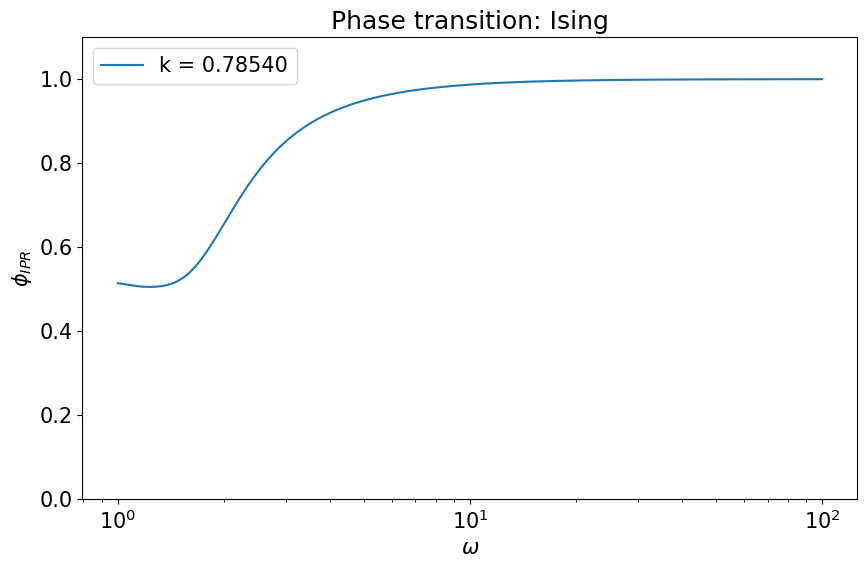

CPU times: user 4.19 s, sys: 640 ms, total: 4.83 s
Wall time: 4.3 s


In [121]:
%%time
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.special import j0, jn_zeros
import traceback

plt.rcParams.update({"figure.figsize": (10, 6),"text.usetex": False,"font.size": 15})
freezing_pts = jn_zeros(0, 5)

omegas = np.exp(np.linspace(np.log(1), np.log(100), 500))
delta = 1e-4
ks = [np.pi/4]

for k in ks:
    iprvals_exact = np.array([get_iprvals_exact(w, k, sort=True) for w in omegas])
    plt.plot(omegas, iprvals_exact[:,0], label = fr"k = {k:1.5f}")

plt.title(fr'Phase transition: Ising' )
plt.xscale('log')
plt.xlabel(r'$\omega$')
plt.ylabel(r"$\phi_{{IPR}}$")
plt.legend()
plt.ylim(0.0,1.1)
plt.savefig('phase_transition_ising.jpeg', dpi = 800)
plt.show()

### Ising Exact

In [115]:
%%time
import numpy as np
from qutip import tensor, sigmax, sigmay, sigmaz, qeye, mesolve 
from qutip.floquet import floquet_modes
from scipy.special import j0

def drive(t, args):
    h0 = args['h0']
    h = args['h']
    w = args['omega']
    return h0 + h * np.cos(w * t)

def get_floquet_isingfermion(k, args, **kwargs):
    
    sx = sigmax()
    sz = sigmaz()
    
    # construct the hamiltonian
    H0 = np.sin(k) * sx + np.cos(k) * sz
    H1 = sz
    
    H = [H0,[H1,drive]]    
    T = 2 * np.pi/args['omega']

    return floquet_modes(H, T, args, **kwargs)

def get_iprvals_exact(k, params, **kwargs):
    f_states, f_energies = get_floquet_isingfermion(k, params, **kwargs)
    floquet_matrix = np.array(f_states)[:,:,0]
    return np.sum(np.abs(floquet_matrix)**4, axis=-1)

CPU times: user 43 µs, sys: 3 µs, total: 46 µs
Wall time: 49.6 µs


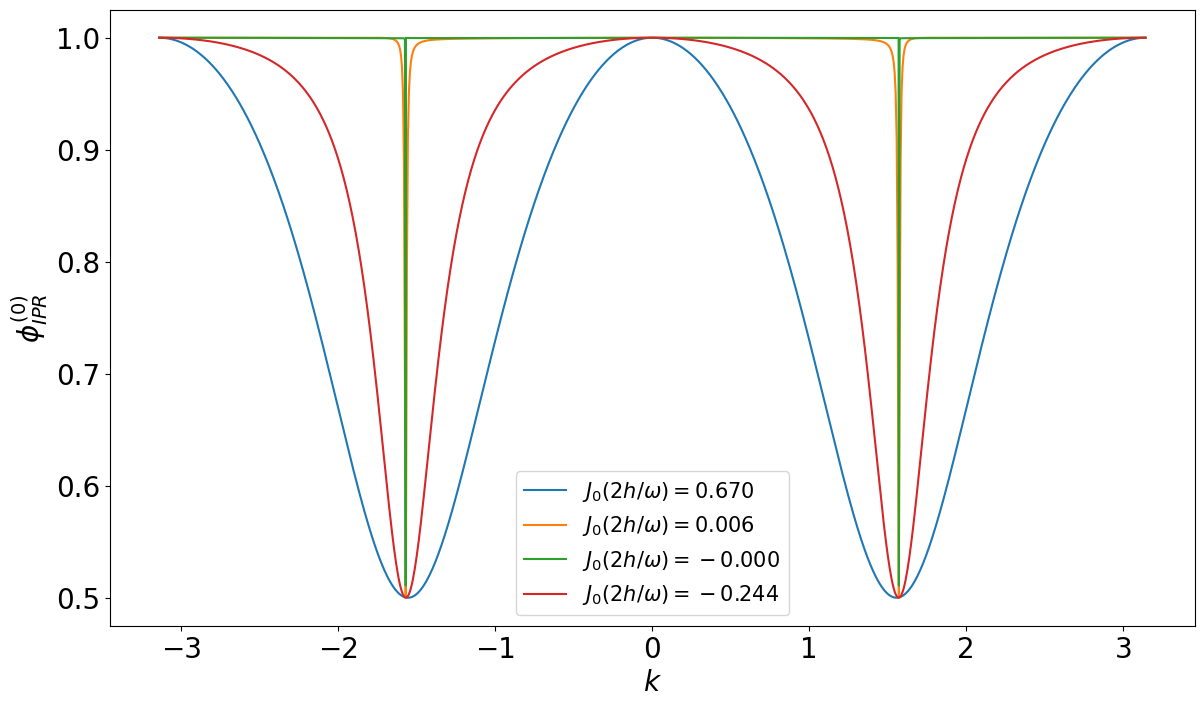

CPU times: user 15.2 s, sys: 623 ms, total: 15.8 s
Wall time: 15.3 s


In [116]:
%%time
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.special import j0, jn_zeros
from tqdm import tqdm
import traceback

plt.rcParams.update({
    "figure.figsize": (14, 8),
    "text.usetex": False,
    "font.size": 20})

freezing_pts = jn_zeros(0, 5)
max_pts = jn_zeros(1,5)

#
# set up the calculation
#
omega = 90.0
w = omega
hfrz = omega * freezing_pts/2
hmed = 0.995 * omega * freezing_pts/2
hmax = 1.25 * omega * max_pts/2
hfin = 0.5 * omega * freezing_pts/2


delta = 1e-4
fbz = np.linspace(-np.pi+delta, np.pi-delta, 1000)
aa = [-np.pi/2.0,np.pi/2.0]
fbz = np.sort(np.append(fbz,aa))

for h in np.sort([hfrz[0], hmed[0], hmax[0], hfin[0]]):
    params = {'h0':0.0, 'h':h, 'omega':omega}
    iprvals_exact = np.array([get_iprvals_exact(k, params, sort=True) for k in fbz])
    plt.plot(fbz, iprvals_exact[:,0], label=fr"$J_0(2h/\omega)={j0(2*h/w):1.3f}$")

plt.ylabel(f'$\phi^{{({{0}})}}_{{IPR}}$')
plt.xlabel(r'$k$')
plt.legend(fontsize = 15)
plt.savefig('ising_exact.jpeg', dpi = 800)
plt.show()